In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(18269, 4) (12195, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 1s 1s/step - loss: 97724.0781
Epoch 2/3000
1/1 [==============================] - 0s 12ms/step - loss: 97278.6562
Epoch 3/3000
1/1 [==============================] - 0s 11ms/step - loss: 96964.2109
Epoch 4/3000
1/1 [==============================] - 0s 10ms/step - loss: 96704.5938
Epoch 5/3000
1/1 [==============================] - 0s 10ms/step - loss: 96475.5156
Epoch 6/3000
1/1 [==============================] - 0s 11ms/step - loss: 96266.0391
Epoch 7/3000
1/1 [==============================] - 0s 10ms/step - loss: 96070.5547
Epoch 8/3000
1/1 [==============================] - 0s 9ms/step - loss: 95885.8750
Epoch 9/3000
1/1 [==============================] - 0s 12ms/step - loss: 95709.8828
Epoch 10/3000
1/1 [==============================] - 0s 12ms/step - loss: 95541.0312
Epoch 11/3000
1/1 [==============================] - 0s 10ms/step - loss: 95378.1328
Epoch 12/3000
1/1 [==============================] - 0s 10ms/step - loss: 952

1/1 [==============================] - 0s 12ms/step - loss: 85731.8672
Epoch 99/3000
1/1 [==============================] - 0s 13ms/step - loss: 85651.8203
Epoch 100/3000
1/1 [==============================] - 0s 12ms/step - loss: 85572.3125
Epoch 101/3000
1/1 [==============================] - 0s 13ms/step - loss: 85493.3203
Epoch 102/3000
1/1 [==============================] - 0s 12ms/step - loss: 85414.8594
Epoch 103/3000
1/1 [==============================] - 0s 11ms/step - loss: 85336.8984
Epoch 104/3000
1/1 [==============================] - 0s 12ms/step - loss: 85259.4531
Epoch 105/3000
1/1 [==============================] - 0s 12ms/step - loss: 85182.5000
Epoch 106/3000
1/1 [==============================] - 0s 14ms/step - loss: 85106.0469
Epoch 107/3000
1/1 [==============================] - 0s 12ms/step - loss: 85030.0703
Epoch 108/3000
1/1 [==============================] - 0s 12ms/step - loss: 84954.5781
Epoch 109/3000
1/1 [==============================] - 0s 11ms/step - l

1/1 [==============================] - 0s 13ms/step - loss: 79822.8594
Epoch 194/3000
1/1 [==============================] - 0s 12ms/step - loss: 79772.9453
Epoch 195/3000
1/1 [==============================] - 0s 13ms/step - loss: 79723.1797
Epoch 196/3000
1/1 [==============================] - 0s 12ms/step - loss: 79673.5469
Epoch 197/3000
1/1 [==============================] - 0s 15ms/step - loss: 79624.0547
Epoch 198/3000
1/1 [==============================] - 0s 12ms/step - loss: 79574.6719
Epoch 199/3000
1/1 [==============================] - 0s 13ms/step - loss: 79525.4219
Epoch 200/3000
1/1 [==============================] - 0s 13ms/step - loss: 79476.2891
Epoch 201/3000
1/1 [==============================] - 0s 13ms/step - loss: 79427.2344
Epoch 202/3000
1/1 [==============================] - 0s 13ms/step - loss: 79378.2734
Epoch 203/3000
1/1 [==============================] - 0s 14ms/step - loss: 79329.3828
Epoch 204/3000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 12ms/step - loss: 74132.7656
Epoch 289/3000
1/1 [==============================] - 0s 14ms/step - loss: 74069.1250
Epoch 290/3000
1/1 [==============================] - 0s 12ms/step - loss: 74005.6172
Epoch 291/3000
1/1 [==============================] - 0s 14ms/step - loss: 73942.2344
Epoch 292/3000
1/1 [==============================] - 0s 12ms/step - loss: 73878.9844
Epoch 293/3000
1/1 [==============================] - 0s 14ms/step - loss: 73815.8750
Epoch 294/3000
1/1 [==============================] - 0s 12ms/step - loss: 73752.8906
Epoch 295/3000
1/1 [==============================] - 0s 15ms/step - loss: 73690.0156
Epoch 296/3000
1/1 [==============================] - 0s 12ms/step - loss: 73627.2578
Epoch 297/3000
1/1 [==============================] - 0s 13ms/step - loss: 73564.5938
Epoch 298/3000
1/1 [==============================] - 0s 12ms/step - loss: 73502.0469
Epoch 299/3000
1/1 [==============================] - 0s 13ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 68499.1250
Epoch 384/3000
1/1 [==============================] - 0s 13ms/step - loss: 68443.5938
Epoch 385/3000
1/1 [==============================] - 0s 15ms/step - loss: 68388.0312
Epoch 386/3000
1/1 [==============================] - 0s 16ms/step - loss: 68332.6406
Epoch 387/3000
1/1 [==============================] - 0s 16ms/step - loss: 68277.2188
Epoch 388/3000
1/1 [==============================] - 0s 15ms/step - loss: 68221.9688
Epoch 389/3000
1/1 [==============================] - 0s 13ms/step - loss: 68166.7031
Epoch 390/3000
1/1 [==============================] - 0s 13ms/step - loss: 68111.6172
Epoch 391/3000
1/1 [==============================] - 0s 12ms/step - loss: 68056.5000
Epoch 392/3000
1/1 [==============================] - 0s 12ms/step - loss: 68001.5859
Epoch 393/3000
1/1 [==============================] - 0s 13ms/step - loss: 67946.6484
Epoch 394/3000
1/1 [==============================] - 0s 13ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 63698.0742
Epoch 479/3000
1/1 [==============================] - 0s 12ms/step - loss: 63652.7695
Epoch 480/3000
1/1 [==============================] - 0s 11ms/step - loss: 63607.6484
Epoch 481/3000
1/1 [==============================] - 0s 11ms/step - loss: 63562.5469
Epoch 482/3000
1/1 [==============================] - 0s 13ms/step - loss: 63517.6172
Epoch 483/3000
1/1 [==============================] - 0s 14ms/step - loss: 63472.6992
Epoch 484/3000
1/1 [==============================] - 0s 13ms/step - loss: 63427.9492
Epoch 485/3000
1/1 [==============================] - 0s 17ms/step - loss: 63383.2266
Epoch 486/3000
1/1 [==============================] - 0s 18ms/step - loss: 63338.6602
Epoch 487/3000
1/1 [==============================] - 0s 19ms/step - loss: 63294.1133
Epoch 488/3000
1/1 [==============================] - 0s 17ms/step - loss: 63249.7383
Epoch 489/3000
1/1 [==============================] - 0s 17ms/step - 

1/1 [==============================] - 0s 19ms/step - loss: 59790.8203
Epoch 574/3000
1/1 [==============================] - 0s 18ms/step - loss: 59753.6992
Epoch 575/3000
1/1 [==============================] - 0s 18ms/step - loss: 59716.6016
Epoch 576/3000
1/1 [==============================] - 0s 20ms/step - loss: 59679.6328
Epoch 577/3000
1/1 [==============================] - 0s 19ms/step - loss: 59642.6953
Epoch 578/3000
1/1 [==============================] - 0s 21ms/step - loss: 59605.8789
Epoch 579/3000
1/1 [==============================] - 0s 17ms/step - loss: 59569.1016
Epoch 580/3000
1/1 [==============================] - 0s 18ms/step - loss: 59532.4219
Epoch 581/3000
1/1 [==============================] - 0s 19ms/step - loss: 59495.8086
Epoch 582/3000
1/1 [==============================] - 0s 17ms/step - loss: 59459.2812
Epoch 583/3000
1/1 [==============================] - 0s 19ms/step - loss: 59422.8438
Epoch 584/3000
1/1 [==============================] - 0s 17ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 56581.4297
Epoch 669/3000
1/1 [==============================] - 0s 11ms/step - loss: 56550.9922
Epoch 670/3000
1/1 [==============================] - 0s 13ms/step - loss: 56520.3125
Epoch 671/3000
1/1 [==============================] - 0s 11ms/step - loss: 56489.9688
Epoch 672/3000
1/1 [==============================] - 0s 12ms/step - loss: 56459.4141
Epoch 673/3000
1/1 [==============================] - 0s 11ms/step - loss: 56429.1328
Epoch 674/3000
1/1 [==============================] - 0s 11ms/step - loss: 56398.6562
Epoch 675/3000
1/1 [==============================] - 0s 10ms/step - loss: 56368.4922
Epoch 676/3000
1/1 [==============================] - 0s 10ms/step - loss: 56338.1094
Epoch 677/3000
1/1 [==============================] - 0s 10ms/step - loss: 56308.1250
Epoch 678/3000
1/1 [==============================] - 0s 11ms/step - loss: 56277.8359
Epoch 679/3000
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 53920.0000
Epoch 764/3000
1/1 [==============================] - 0s 9ms/step - loss: 53894.0898
Epoch 765/3000
1/1 [==============================] - 0s 9ms/step - loss: 53868.9883
Epoch 766/3000
1/1 [==============================] - 0s 9ms/step - loss: 53843.1406
Epoch 767/3000
1/1 [==============================] - 0s 9ms/step - loss: 53818.1719
Epoch 768/3000
1/1 [==============================] - 0s 9ms/step - loss: 53792.3906
Epoch 769/3000
1/1 [==============================] - 0s 9ms/step - loss: 53767.5312
Epoch 770/3000
1/1 [==============================] - 0s 10ms/step - loss: 53741.8438
Epoch 771/3000
1/1 [==============================] - 0s 9ms/step - loss: 53717.0781
Epoch 772/3000
1/1 [==============================] - 0s 9ms/step - loss: 53691.5430
Epoch 773/3000
1/1 [==============================] - 0s 9ms/step - loss: 53666.8555
Epoch 774/3000
1/1 [==============================] - 0s 10ms/step - loss: 5364

Epoch 859/3000
1/1 [==============================] - 0s 10ms/step - loss: 51679.1016
Epoch 860/3000
1/1 [==============================] - 0s 10ms/step - loss: 51657.0898
Epoch 861/3000
1/1 [==============================] - 0s 9ms/step - loss: 51636.6914
Epoch 862/3000
1/1 [==============================] - 0s 9ms/step - loss: 51614.8164
Epoch 863/3000
1/1 [==============================] - 0s 9ms/step - loss: 51594.4688
Epoch 864/3000
1/1 [==============================] - 0s 10ms/step - loss: 51572.8750
Epoch 865/3000
1/1 [==============================] - 0s 10ms/step - loss: 51552.5391
Epoch 866/3000
1/1 [==============================] - 0s 9ms/step - loss: 51531.1133
Epoch 867/3000
1/1 [==============================] - 0s 9ms/step - loss: 51510.6719
Epoch 868/3000
1/1 [==============================] - 0s 9ms/step - loss: 51489.2656
Epoch 869/3000
1/1 [==============================] - 0s 9ms/step - loss: 51468.8516
Epoch 870/3000
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 9ms/step - loss: 49838.8594
Epoch 956/3000
1/1 [==============================] - 0s 10ms/step - loss: 49820.8984
Epoch 957/3000
1/1 [==============================] - 0s 9ms/step - loss: 49804.6719
Epoch 958/3000
1/1 [==============================] - 0s 8ms/step - loss: 49787.2656
Epoch 959/3000
1/1 [==============================] - 0s 9ms/step - loss: 49770.7773
Epoch 960/3000
1/1 [==============================] - 0s 10ms/step - loss: 49753.3906
Epoch 961/3000
1/1 [==============================] - 0s 9ms/step - loss: 49736.5469
Epoch 962/3000
1/1 [==============================] - 0s 9ms/step - loss: 49719.0469
Epoch 963/3000
1/1 [==============================] - 0s 8ms/step - loss: 49702.4219
Epoch 964/3000
1/1 [==============================] - 0s 9ms/step - loss: 49685.0312
Epoch 965/3000
1/1 [==============================] - 0s 9ms/step - loss: 49669.0859
Epoch 966/3000
1/1 [==============================] - 0s 10ms/step - loss: 496

1/1 [==============================] - 0s 9ms/step - loss: 48382.2109
Epoch 1051/3000
1/1 [==============================] - 0s 9ms/step - loss: 48369.8438
Epoch 1052/3000
1/1 [==============================] - 0s 8ms/step - loss: 48354.4375
Epoch 1053/3000
1/1 [==============================] - 0s 9ms/step - loss: 48341.8281
Epoch 1054/3000
1/1 [==============================] - 0s 9ms/step - loss: 48327.3984
Epoch 1055/3000
1/1 [==============================] - 0s 9ms/step - loss: 48314.9805
Epoch 1056/3000
1/1 [==============================] - 0s 9ms/step - loss: 48301.5820
Epoch 1057/3000
1/1 [==============================] - 0s 10ms/step - loss: 48288.8516
Epoch 1058/3000
1/1 [==============================] - 0s 9ms/step - loss: 48275.5234
Epoch 1059/3000
1/1 [==============================] - 0s 9ms/step - loss: 48261.8203
Epoch 1060/3000
1/1 [==============================] - 0s 9ms/step - loss: 48247.9883
Epoch 1061/3000
1/1 [==============================] - 0s 9ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 47235.8125
Epoch 1146/3000
1/1 [==============================] - 0s 9ms/step - loss: 47225.2422
Epoch 1147/3000
1/1 [==============================] - 0s 9ms/step - loss: 47215.6641
Epoch 1148/3000
1/1 [==============================] - 0s 9ms/step - loss: 47205.6992
Epoch 1149/3000
1/1 [==============================] - 0s 10ms/step - loss: 47197.4180
Epoch 1150/3000
1/1 [==============================] - 0s 9ms/step - loss: 47185.7070
Epoch 1151/3000
1/1 [==============================] - 0s 8ms/step - loss: 47176.2188
Epoch 1152/3000
1/1 [==============================] - 0s 9ms/step - loss: 47163.0781
Epoch 1153/3000
1/1 [==============================] - 0s 9ms/step - loss: 47152.9375
Epoch 1154/3000
1/1 [==============================] - 0s 9ms/step - loss: 47141.3906
Epoch 1155/3000
1/1 [==============================] - 0s 8ms/step - loss: 47131.8203
Epoch 1156/3000
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 46354.2578
Epoch 1241/3000
1/1 [==============================] - 0s 9ms/step - loss: 46347.0156
Epoch 1242/3000
1/1 [==============================] - 0s 9ms/step - loss: 46340.3906
Epoch 1243/3000
1/1 [==============================] - 0s 8ms/step - loss: 46331.6719
Epoch 1244/3000
1/1 [==============================] - 0s 9ms/step - loss: 46323.8828
Epoch 1245/3000
1/1 [==============================] - 0s 8ms/step - loss: 46314.3828
Epoch 1246/3000
1/1 [==============================] - 0s 9ms/step - loss: 46306.4062
Epoch 1247/3000
1/1 [==============================] - 0s 9ms/step - loss: 46298.3672
Epoch 1248/3000
1/1 [==============================] - 0s 9ms/step - loss: 46291.3203
Epoch 1249/3000
1/1 [==============================] - 0s 8ms/step - loss: 46285.3359
Epoch 1250/3000
1/1 [==============================] - 0s 9ms/step - loss: 46278.3516
Epoch 1251/3000
1/1 [==============================] - 0s 9ms/step - l

Epoch 1335/3000
1/1 [==============================] - 0s 11ms/step - loss: 45740.9570
Epoch 1336/3000
1/1 [==============================] - 0s 12ms/step - loss: 45734.7617
Epoch 1337/3000
1/1 [==============================] - 0s 11ms/step - loss: 45728.1484
Epoch 1338/3000
1/1 [==============================] - 0s 12ms/step - loss: 45720.7188
Epoch 1339/3000
1/1 [==============================] - 0s 12ms/step - loss: 45715.9766
Epoch 1340/3000
1/1 [==============================] - 0s 11ms/step - loss: 45710.3789
Epoch 1341/3000
1/1 [==============================] - 0s 11ms/step - loss: 45705.3672
Epoch 1342/3000
1/1 [==============================] - 0s 12ms/step - loss: 45702.5859
Epoch 1343/3000
1/1 [==============================] - 0s 11ms/step - loss: 45696.9844
Epoch 1344/3000
1/1 [==============================] - 0s 12ms/step - loss: 45693.0703
Epoch 1345/3000
1/1 [==============================] - 0s 12ms/step - loss: 45686.1562
Epoch 1346/3000
1/1 [======================

Epoch 1430/3000
1/1 [==============================] - 0s 11ms/step - loss: 45328.1953
Epoch 1431/3000
1/1 [==============================] - 0s 11ms/step - loss: 45328.6250
Epoch 1432/3000
1/1 [==============================] - 0s 11ms/step - loss: 45328.8008
Epoch 1433/3000
1/1 [==============================] - 0s 11ms/step - loss: 45327.9883
Epoch 1434/3000
1/1 [==============================] - 0s 11ms/step - loss: 45327.6406
Epoch 1435/3000
1/1 [==============================] - 0s 11ms/step - loss: 45313.0508
Epoch 1436/3000
1/1 [==============================] - 0s 12ms/step - loss: 45305.0938
Epoch 1437/3000
1/1 [==============================] - 0s 11ms/step - loss: 45300.8672
Epoch 1438/3000
1/1 [==============================] - 0s 11ms/step - loss: 45295.6133
Epoch 1439/3000
1/1 [==============================] - 0s 11ms/step - loss: 45291.2422
Epoch 1440/3000
1/1 [==============================] - 0s 11ms/step - loss: 45287.3281
Epoch 1441/3000
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 45040.0547
Epoch 1525/3000
1/1 [==============================] - 0s 10ms/step - loss: 45036.7656
Epoch 1526/3000
1/1 [==============================] - 0s 10ms/step - loss: 45033.6836
Epoch 1527/3000
1/1 [==============================] - 0s 9ms/step - loss: 45031.8594
Epoch 1528/3000
1/1 [==============================] - 0s 9ms/step - loss: 45030.7734
Epoch 1529/3000
1/1 [==============================] - 0s 10ms/step - loss: 45031.4609
Epoch 1530/3000
1/1 [==============================] - 0s 9ms/step - loss: 45032.9102
Epoch 1531/3000
1/1 [==============================] - 0s 10ms/step - loss: 45029.0312
Epoch 1532/3000
1/1 [==============================] - 0s 9ms/step - loss: 45024.5000
Epoch 1533/3000
1/1 [==============================] - 0s 10ms/step - loss: 45018.4961
Epoch 1534/3000
1/1 [==============================] - 0s 9ms/step - loss: 45014.2734
Epoch 1535/3000
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 10ms/step - loss: 44837.5352
Epoch 1619/3000
1/1 [==============================] - 0s 10ms/step - loss: 44838.3594
Epoch 1620/3000
1/1 [==============================] - 0s 10ms/step - loss: 44840.7109
Epoch 1621/3000
1/1 [==============================] - 0s 9ms/step - loss: 44840.4102
Epoch 1622/3000
1/1 [==============================] - 0s 10ms/step - loss: 44840.0000
Epoch 1623/3000
1/1 [==============================] - 0s 9ms/step - loss: 44832.9062
Epoch 1624/3000
1/1 [==============================] - 0s 9ms/step - loss: 44828.8984
Epoch 1625/3000
1/1 [==============================] - 0s 10ms/step - loss: 44827.4180
Epoch 1626/3000
1/1 [==============================] - 0s 9ms/step - loss: 44826.1484
Epoch 1627/3000
1/1 [==============================] - 0s 9ms/step - loss: 44824.4766
Epoch 1628/3000
1/1 [==============================] - 0s 9ms/step - loss: 44822.5508
Epoch 1629/3000
1/1 [==============================] - 0s 9ms/ste

1/1 [==============================] - 0s 9ms/step - loss: 44699.9961
Epoch 1714/3000
1/1 [==============================] - 0s 9ms/step - loss: 44706.1523
Epoch 1715/3000
1/1 [==============================] - 0s 9ms/step - loss: 44709.4961
Epoch 1716/3000
1/1 [==============================] - 0s 9ms/step - loss: 44702.3750
Epoch 1717/3000
1/1 [==============================] - 0s 9ms/step - loss: 44695.3125
Epoch 1718/3000
1/1 [==============================] - 0s 9ms/step - loss: 44687.5430
Epoch 1719/3000
1/1 [==============================] - 0s 9ms/step - loss: 44682.2578
Epoch 1720/3000
1/1 [==============================] - 0s 9ms/step - loss: 44677.7188
Epoch 1721/3000
1/1 [==============================] - 0s 9ms/step - loss: 44676.0547
Epoch 1722/3000
1/1 [==============================] - 0s 9ms/step - loss: 44673.9062
Epoch 1723/3000
1/1 [==============================] - 0s 9ms/step - loss: 44674.3281
Epoch 1724/3000
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 44584.4297
Epoch 1809/3000
1/1 [==============================] - 0s 9ms/step - loss: 44579.3438
Epoch 1810/3000
1/1 [==============================] - 0s 9ms/step - loss: 44578.8203
Epoch 1811/3000
1/1 [==============================] - 0s 8ms/step - loss: 44576.6680
Epoch 1812/3000
1/1 [==============================] - 0s 9ms/step - loss: 44579.4219
Epoch 1813/3000
1/1 [==============================] - 0s 9ms/step - loss: 44583.4492
Epoch 1814/3000
1/1 [==============================] - 0s 9ms/step - loss: 44584.6758
Epoch 1815/3000
1/1 [==============================] - 0s 9ms/step - loss: 44588.6875
Epoch 1816/3000
1/1 [==============================] - 0s 9ms/step - loss: 44580.3281
Epoch 1817/3000
1/1 [==============================] - 0s 11ms/step - loss: 44577.8906
Epoch 1818/3000
1/1 [==============================] - 0s 13ms/step - loss: 44576.4844
Epoch 1819/3000
1/1 [==============================] - 0s 12ms/step 

1/1 [==============================] - 0s 10ms/step - loss: 44502.8359
Epoch 1903/3000
1/1 [==============================] - 0s 10ms/step - loss: 44503.1797
Epoch 1904/3000
1/1 [==============================] - 0s 10ms/step - loss: 44504.0625
Epoch 1905/3000
1/1 [==============================] - 0s 10ms/step - loss: 44502.9883
Epoch 1906/3000
1/1 [==============================] - 0s 8ms/step - loss: 44505.0586
Epoch 1907/3000
1/1 [==============================] - 0s 10ms/step - loss: 44503.7656
Epoch 1908/3000
1/1 [==============================] - 0s 10ms/step - loss: 44504.4297
Epoch 1909/3000
1/1 [==============================] - 0s 9ms/step - loss: 44500.5820
Epoch 1910/3000
1/1 [==============================] - 0s 9ms/step - loss: 44502.5000
Epoch 1911/3000
1/1 [==============================] - 0s 9ms/step - loss: 44498.9648
Epoch 1912/3000
1/1 [==============================] - 0s 9ms/step - loss: 44499.2969
Epoch 1913/3000
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 9ms/step - loss: 44448.9336
Epoch 1998/3000
1/1 [==============================] - 0s 8ms/step - loss: 44444.0664
Epoch 1999/3000
1/1 [==============================] - 0s 9ms/step - loss: 44441.6445
Epoch 2000/3000
1/1 [==============================] - 0s 9ms/step - loss: 44439.0547
Epoch 2001/3000
1/1 [==============================] - 0s 9ms/step - loss: 44436.7344
Epoch 2002/3000
1/1 [==============================] - 0s 9ms/step - loss: 44438.7422
Epoch 2003/3000
1/1 [==============================] - 0s 9ms/step - loss: 44439.5391
Epoch 2004/3000
1/1 [==============================] - 0s 9ms/step - loss: 44442.9062
Epoch 2005/3000
1/1 [==============================] - 0s 9ms/step - loss: 44442.1172
Epoch 2006/3000
1/1 [==============================] - 0s 9ms/step - loss: 44444.3984
Epoch 2007/3000
1/1 [==============================] - 0s 10ms/step - loss: 44442.5742
Epoch 2008/3000
1/1 [==============================] - 0s 10ms/step -

1/1 [==============================] - 0s 9ms/step - loss: 44397.0938
Epoch 2092/3000
1/1 [==============================] - 0s 9ms/step - loss: 44390.9258
Epoch 2093/3000
1/1 [==============================] - 0s 9ms/step - loss: 44392.5977
Epoch 2094/3000
1/1 [==============================] - 0s 8ms/step - loss: 44392.1406
Epoch 2095/3000
1/1 [==============================] - 0s 9ms/step - loss: 44390.6016
Epoch 2096/3000
1/1 [==============================] - 0s 10ms/step - loss: 44395.3828
Epoch 2097/3000
1/1 [==============================] - 0s 10ms/step - loss: 44394.2891
Epoch 2098/3000
1/1 [==============================] - 0s 9ms/step - loss: 44396.3555
Epoch 2099/3000
1/1 [==============================] - 0s 8ms/step - loss: 44392.0312
Epoch 2100/3000
1/1 [==============================] - 0s 10ms/step - loss: 44398.0156
Epoch 2101/3000
1/1 [==============================] - 0s 9ms/step - loss: 44412.8672
Epoch 2102/3000
1/1 [==============================] - 0s 11ms/step

Epoch 2186/3000
1/1 [==============================] - 0s 9ms/step - loss: 44356.7578
Epoch 2187/3000
1/1 [==============================] - 0s 9ms/step - loss: 44349.4219
Epoch 2188/3000
1/1 [==============================] - 0s 10ms/step - loss: 44353.0234
Epoch 2189/3000
1/1 [==============================] - 0s 9ms/step - loss: 44345.6328
Epoch 2190/3000
1/1 [==============================] - 0s 9ms/step - loss: 44346.7578
Epoch 2191/3000
1/1 [==============================] - 0s 9ms/step - loss: 44341.7461
Epoch 2192/3000
1/1 [==============================] - 0s 9ms/step - loss: 44342.0078
Epoch 2193/3000
1/1 [==============================] - 0s 11ms/step - loss: 44344.8203
Epoch 2194/3000
1/1 [==============================] - 0s 9ms/step - loss: 44346.8516
Epoch 2195/3000
1/1 [==============================] - 0s 10ms/step - loss: 44355.8086
Epoch 2196/3000
1/1 [==============================] - 0s 9ms/step - loss: 44342.9492
Epoch 2197/3000
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 44291.8711
Epoch 2281/3000
1/1 [==============================] - 0s 14ms/step - loss: 44295.2500
Epoch 2282/3000
1/1 [==============================] - 0s 15ms/step - loss: 44292.3047
Epoch 2283/3000
1/1 [==============================] - 0s 14ms/step - loss: 44297.3047
Epoch 2284/3000
1/1 [==============================] - 0s 15ms/step - loss: 44297.0781
Epoch 2285/3000
1/1 [==============================] - 0s 15ms/step - loss: 44307.0898
Epoch 2286/3000
1/1 [==============================] - 0s 16ms/step - loss: 44314.6328
Epoch 2287/3000
1/1 [==============================] - 0s 24ms/step - loss: 44329.3906
Epoch 2288/3000
1/1 [==============================] - 0s 16ms/step - loss: 44334.1484
Epoch 2289/3000
1/1 [==============================] - 0s 16ms/step - loss: 44326.3398
Epoch 2290/3000
1/1 [==============================] - 0s 16ms/step - loss: 44317.3047
Epoch 2291/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: 44271.6797
Epoch 2376/3000
1/1 [==============================] - 0s 17ms/step - loss: 44266.6719
Epoch 2377/3000
1/1 [==============================] - 0s 15ms/step - loss: 44267.4336
Epoch 2378/3000
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 2379/3000
1/1 [==============================] - 0s 13ms/step - loss: 44266.0508
Epoch 2380/3000
1/1 [==============================] - 0s 13ms/step - loss: 44269.1289
Epoch 2381/3000
1/1 [==============================] - 0s 12ms/step - loss: 44271.4766
Epoch 2382/3000
1/1 [==============================] - 0s 13ms/step - loss: nan
Epoch 2383/3000
1/1 [==============================] - 0s 12ms/step - loss: 44274.6875
Epoch 2384/3000
1/1 [==============================] - 0s 12ms/step - loss: 44272.8477
Epoch 2385/3000
1/1 [==============================] - 0s 13ms/step - loss: 44275.4375
Epoch 2386/3000
1/1 [==============================] - 0s 12ms/step - los

1/1 [==============================] - 0s 11ms/step - loss: 44220.2305
Epoch 2472/3000
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2473/3000
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2474/3000
1/1 [==============================] - 0s 11ms/step - loss: 44233.5273
Epoch 2475/3000
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2476/3000
1/1 [==============================] - 0s 9ms/step - loss: 44246.5625
Epoch 2477/3000
1/1 [==============================] - 0s 12ms/step - loss: 44249.6562
Epoch 2478/3000
1/1 [==============================] - 0s 11ms/step - loss: 44252.0156
Epoch 2479/3000
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2480/3000
1/1 [==============================] - 0s 10ms/step - loss: 44235.5781
Epoch 2481/3000
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2482/3000
1/1 [==============================] - 0s 10ms/step - loss: 44227.2266
Epoch 2483

1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2570/3000
1/1 [==============================] - 0s 9ms/step - loss: 44195.9102
Epoch 2571/3000
1/1 [==============================] - 0s 9ms/step - loss: 44206.0977
Epoch 2572/3000
1/1 [==============================] - 0s 9ms/step - loss: 44222.6172
Epoch 2573/3000
1/1 [==============================] - 0s 10ms/step - loss: 44230.4297
Epoch 2574/3000
1/1 [==============================] - 0s 9ms/step - loss: 44222.8555
Epoch 2575/3000
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2576/3000
1/1 [==============================] - 0s 10ms/step - loss: 44201.9922
Epoch 2577/3000
1/1 [==============================] - 0s 10ms/step - loss: 44193.8516
Epoch 2578/3000
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2579/3000
1/1 [==============================] - 0s 9ms/step - loss: 44191.3359
Epoch 2580/3000
1/1 [==============================] - 0s 9ms/step - loss: 44194.8828
Ep

1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2666/3000
1/1 [==============================] - 0s 9ms/step - loss: 44205.4961
Epoch 2667/3000
1/1 [==============================] - 0s 10ms/step - loss: 44185.2969
Epoch 2668/3000
1/1 [==============================] - 0s 10ms/step - loss: 44175.7461
Epoch 2669/3000
1/1 [==============================] - 0s 12ms/step - loss: 44166.9766
Epoch 2670/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2671/3000
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 2672/3000
1/1 [==============================] - 0s 11ms/step - loss: 44159.8594
Epoch 2673/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2674/3000
1/1 [==============================] - 0s 11ms/step - loss: 44171.7656
Epoch 2675/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2676/3000
1/1 [==============================] - 0s 12ms/step - loss: 44178.0625
Epoch 267

1/1 [==============================] - 0s 11ms/step - loss: 44151.3672
Epoch 2763/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2764/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2765/3000
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2766/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2767/3000
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2768/3000
1/1 [==============================] - 0s 11ms/step - loss: 44141.1211
Epoch 2769/3000
1/1 [==============================] - 0s 14ms/step - loss: 44139.0547
Epoch 2770/3000
1/1 [==============================] - 0s 12ms/step - loss: 44153.3477
Epoch 2771/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2772/3000
1/1 [==============================] - 0s 11ms/step - loss: 44167.8242
Epoch 2773/3000
1/1 [==============================] - 0s 11ms/step - loss: 44140.6875
Epoch 2774/300

1/1 [==============================] - 0s 12ms/step - loss: 44130.3555
Epoch 2860/3000
1/1 [==============================] - 0s 12ms/step - loss: 44123.9336
Epoch 2861/3000
1/1 [==============================] - 0s 12ms/step - loss: 44123.8828
Epoch 2862/3000
1/1 [==============================] - 0s 12ms/step - loss: 44119.7383
Epoch 2863/3000
1/1 [==============================] - 0s 12ms/step - loss: 44121.9102
Epoch 2864/3000
1/1 [==============================] - 0s 12ms/step - loss: 44123.1367
Epoch 2865/3000
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2866/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2867/3000
1/1 [==============================] - 0s 11ms/step - loss: 44118.9531
Epoch 2868/3000
1/1 [==============================] - 0s 12ms/step - loss: 44118.7734
Epoch 2869/3000
1/1 [==============================] - 0s 12ms/step - loss: 44125.2695
Epoch 2870/3000
1/1 [==============================] - 0s 11ms/step - los

1/1 [==============================] - 0s 11ms/step - loss: 44109.9102
Epoch 2955/3000
1/1 [==============================] - 0s 11ms/step - loss: 44108.4570
Epoch 2956/3000
1/1 [==============================] - 0s 12ms/step - loss: 44109.5000
Epoch 2957/3000
1/1 [==============================] - 0s 11ms/step - loss: 44108.6875
Epoch 2958/3000
1/1 [==============================] - 0s 11ms/step - loss: 44109.0703
Epoch 2959/3000
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2960/3000
1/1 [==============================] - 0s 12ms/step - loss: 44104.6484
Epoch 2961/3000
1/1 [==============================] - 0s 12ms/step - loss: 44103.1016
Epoch 2962/3000
1/1 [==============================] - 0s 11ms/step - loss: 44105.3828
Epoch 2963/3000
1/1 [==============================] - 0s 11ms/step - loss: 44105.8438
Epoch 2964/3000
1/1 [==============================] - 0s 11ms/step - loss: 44105.9141
Epoch 2965/3000
1/1 [==============================] - 0s 12ms/ste

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

382/382 [==============================] - 0s 594us/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

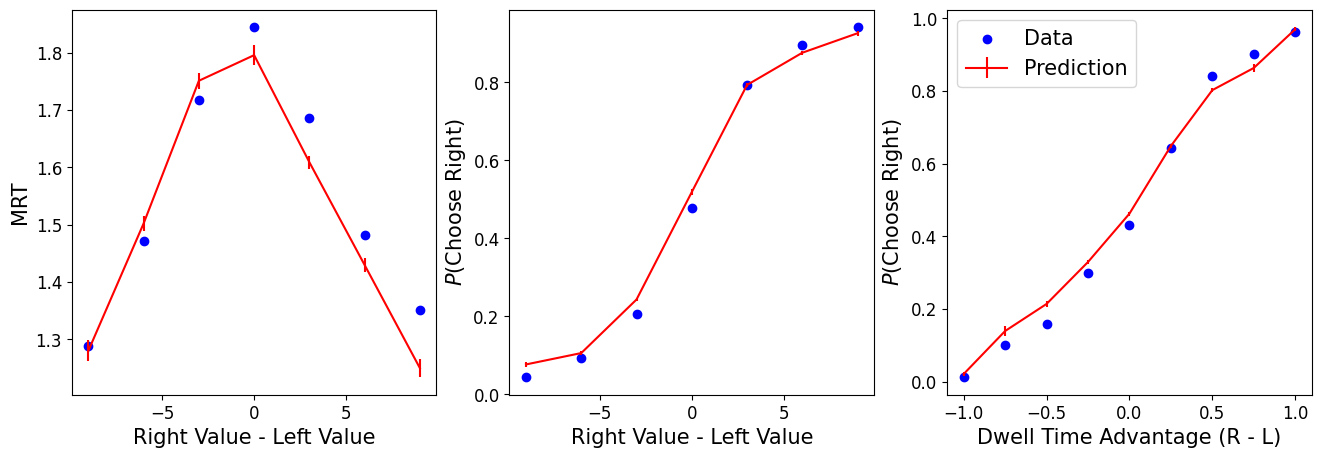

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/tv2017_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

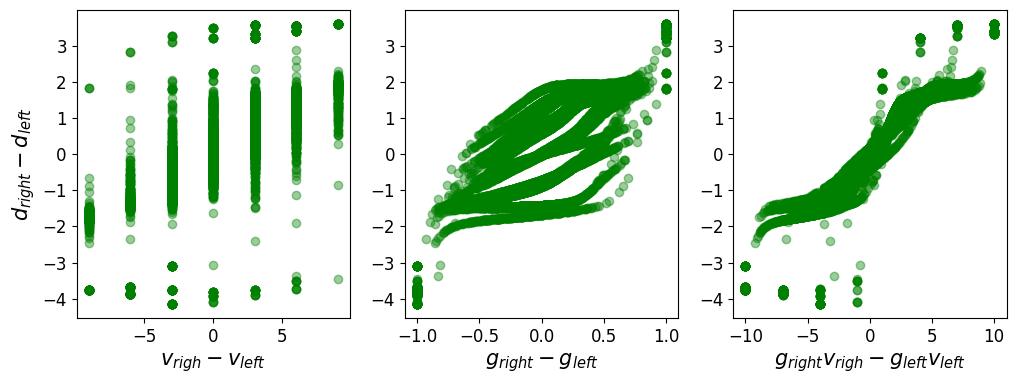

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/tv2017_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');